## Imports

In [24]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import seaborn as sns
import numpy as np
import os
from pathlib import Path
from datetime import datetime
import metpy.io as mtio
import metpy.calc as mtcl
import metpy.units as mtun
import pandas as pd
from tqdm import tqdm
import math

sns.set()

## Reading data

In [2]:
data_dir = Path(os.getcwd()).parent/"data"/"interm"
main_ds = pl.read_csv(data_dir/"train_val.csv", null_values="NA")

In [3]:
print(main_ds.head())

shape: (5, 10)
┌─────────────────────┬────────────────────┬────────┬─────────┬───┬────────────────────┬────────────────────┬────────────────────┬────────┐
│ flightid            ┆ hora_ref           ┆ origem ┆ destino ┆ … ┆ metar              ┆ prev_troca_cabecei ┆ troca_cabeceira_ho ┆ espera │
│ ---                 ┆ ---                ┆ ---    ┆ ---     ┆   ┆ ---                ┆ ra                 ┆ ra_anterior        ┆ ---    │
│ str                 ┆ str                ┆ str    ┆ str     ┆   ┆ str                ┆ ---                ┆ ---                ┆ i64    │
│                     ┆                    ┆        ┆         ┆   ┆                    ┆ i64                ┆ i64                ┆        │
╞═════════════════════╪════════════════════╪════════╪═════════╪═══╪════════════════════╪════════════════════╪════════════════════╪════════╡
│ 504a62621cd231d6ab6 ┆ 2022-06-01T01:00:0 ┆ SBCF   ┆ SBFL    ┆ … ┆ METAR SBFL 010000Z ┆ 0                  ┆ 1                  ┆ 0      │
│ 7e6

In [4]:
main_ds.schema

OrderedDict([('flightid', String),
             ('hora_ref', String),
             ('origem', String),
             ('destino', String),
             ('url_img_satelite', String),
             ('metaf', String),
             ('metar', String),
             ('prev_troca_cabeceira', Int64),
             ('troca_cabeceira_hora_anterior', Int64),
             ('espera', Int64)])

## Description of each column

In [5]:
print(main_ds.describe())

shape: (9, 11)
┌────────────┬────────────────────┬───────────────────┬────────┬───┬───────────────────┬───────────────────┬───────────────────┬──────────┐
│ statistic  ┆ flightid           ┆ hora_ref          ┆ origem ┆ … ┆ metar             ┆ prev_troca_cabece ┆ troca_cabeceira_h ┆ espera   │
│ ---        ┆ ---                ┆ ---               ┆ ---    ┆   ┆ ---               ┆ ira               ┆ ora_anterior      ┆ ---      │
│ str        ┆ str                ┆ str               ┆ str    ┆   ┆ str               ┆ ---               ┆ ---               ┆ f64      │
│            ┆                    ┆                   ┆        ┆   ┆                   ┆ f64               ┆ f64               ┆          │
╞════════════╪════════════════════╪═══════════════════╪════════╪═══╪═══════════════════╪═══════════════════╪═══════════════════╪══════════╡
│ count      ┆ 211679             ┆ 211679            ┆ 211679 ┆ … ┆ 210055            ┆ 211679.0          ┆ 211679.0          ┆ 211679.0 │
│ nul

## Learning to process 'hora_ref'

In [6]:
main_ds["hora_ref"][0] # visualize first element

'2022-06-01T01:00:00Z'

In [7]:
main_ds["hora_ref"].str.ends_with("Z").all() # check if all follow this format

True

### Casting to datetime

In [8]:
main_ds = main_ds.with_columns(
    pl.col("hora_ref").cast(pl.Datetime)
)
print(main_ds.head())

shape: (5, 10)
┌──────────────────────┬──────────────┬────────┬─────────┬───┬──────────────────────┬──────────────────────┬─────────────────────┬────────┐
│ flightid             ┆ hora_ref     ┆ origem ┆ destino ┆ … ┆ metar                ┆ prev_troca_cabeceira ┆ troca_cabeceira_hor ┆ espera │
│ ---                  ┆ ---          ┆ ---    ┆ ---     ┆   ┆ ---                  ┆ ---                  ┆ a_anterior          ┆ ---    │
│ str                  ┆ datetime[μs] ┆ str    ┆ str     ┆   ┆ str                  ┆ i64                  ┆ ---                 ┆ i64    │
│                      ┆              ┆        ┆         ┆   ┆                      ┆                      ┆ i64                 ┆        │
╞══════════════════════╪══════════════╪════════╪═════════╪═══╪══════════════════════╪══════════════════════╪═════════════════════╪════════╡
│ 504a62621cd231d6ab67 ┆ 2022-06-01   ┆ SBCF   ┆ SBFL    ┆ … ┆ METAR SBFL 010000Z   ┆ 0                    ┆ 1                   ┆ 0      │
│ e67

### Visualizing some possible (pre-)features

In [9]:
dt = main_ds["hora_ref"][200]
print(dt.year, dt.month, dt.day, dt.weekday(), dt.hour, dt.minute)

2022 6 1 2 11 0


## Learning to process 'metar' and 'metaf'

In [10]:
i = 0
mtio.metar.parse_metar(main_ds["metar"][i], main_ds["hora_ref"][i].year, main_ds["hora_ref"][i].month)

metar(station_id='SBFL', latitude=-27.67, longitude=-48.53, elevation=5, date_time=datetime.datetime(2022, 6, 1, 0, 0), wind_direction=170, wind_speed=9.0, wind_gust=nan, visibility=9999, current_wx1=nan, current_wx2=nan, current_wx3=nan, skyc1='BKN', skylev1=3000.0, skyc2=nan, skylev2=nan, skyc3=nan, skylev3=nan, skyc4=nan, skylev4=nan, cloudcover=6, temperature=14.0, dewpoint=7.0, altimeter=30.1205829670303, current_wx1_symbol=0, current_wx2_symbol=0, current_wx3_symbol=0, remarks='')

In [11]:
mtio.metar.parse_metar(main_ds["metar"][i], 0, 0)

metar(station_id='SBFL', latitude=-27.67, longitude=-48.53, elevation=5, date_time=nan, wind_direction=170, wind_speed=9.0, wind_gust=nan, visibility=9999, current_wx1=nan, current_wx2=nan, current_wx3=nan, skyc1='BKN', skylev1=3000.0, skyc2=nan, skylev2=nan, skyc3=nan, skylev3=nan, skyc4=nan, skylev4=nan, cloudcover=6, temperature=14.0, dewpoint=7.0, altimeter=30.1205829670303, current_wx1_symbol=0, current_wx2_symbol=0, current_wx3_symbol=0, remarks='')

In [12]:
mtio.metar.parse_metar("METAR ZZZZ 000000Z", 0, 0)

metar(station_id='ZZZZ', latitude=nan, longitude=nan, elevation=nan, date_time=nan, wind_direction=nan, wind_speed=nan, wind_gust=nan, visibility=nan, current_wx1=nan, current_wx2=nan, current_wx3=nan, skyc1=nan, skylev1=nan, skyc2=nan, skylev2=nan, skyc3=nan, skylev3=nan, skyc4=nan, skylev4=nan, cloudcover=10, temperature=nan, dewpoint=nan, altimeter=nan, current_wx1_symbol=0, current_wx2_symbol=0, current_wx3_symbol=0, remarks='')

In [13]:
main_ds = main_ds.with_columns(
    pl.col("metar").fill_null("")
)

In [14]:
def get_parsed_metars(dataset):
    n = dataset.shape[0]
    elevs = []
    temps = []
    dew_pts = []
    visibs = []
    wind_dirs = []
    wind_spds = []
    wind_gusts = []
    skyc1s = []
    skylev1s = []
    skyc2s = []
    skylev2s = []
    skyc3s = []
    skylev3s = []
    skyc4s = []
    skylev4s = []
    cloud_covs = []
    altimeters = []
    pressures = [] # mtcl.altimeter_to_sea_level_pressure

    for i in tqdm(range(n)):
        metar = dataset["metar"][i]
        hora_ref = dataset["hora_ref"][i]
        if metar == "":
            elevs.append(None)
            temps.append(None)
            dew_pts.append(None)
            visibs.append(None)
            wind_dirs.append(None)
            wind_spds.append(None)
            wind_gusts.append(None)
            skyc1s.append(None)
            skylev1s.append(None)
            skyc2s.append(None)
            skylev2s.append(None)
            skyc3s.append(None)
            skylev3s.append(None)
            skyc4s.append(None)
            skylev4s.append(None)
            cloud_covs.append(None)
            altimeters.append(None)
            pressures.append(None)
            continue
        try:
            metar = metar.replace(" COR ", " ")
            metar = metar.replace(" AUTO ", " ")
            metar = metar.replace(" AO1 ", " ")
            metar = metar.replace(" AO2 ", " ")
            metar = mtio.metar.parse_metar(metar, hora_ref.year, hora_ref.month)
            elevs.append(None if math.isnan(metar.elevation) else metar.elevation)
            temps.append(None if math.isnan(metar.temperature) else metar.temperature)
            dew_pts.append(None if math.isnan(metar.dewpoint) else metar.dewpoint)
            visibs.append(None if math.isnan(metar.visibility) else metar.visibility)
            wind_dirs.append(None if math.isnan(metar.wind_direction) else np.deg2rad(metar.wind_direction))
            wind_spds.append(None if math.isnan(metar.wind_speed) else metar.wind_speed)
            wind_gusts.append(None if math.isnan(metar.wind_gust) else metar.wind_gust)
            skyc1s.append(None if type(metar.skyc1) != str else metar.skyc1)
            skylev1s.append(None if math.isnan(metar.skylev1) else metar.skylev1)
            skyc2s.append(None if type(metar.skyc2) != str else metar.skyc2)
            skylev2s.append(None if math.isnan(metar.skylev2) else metar.skylev2)
            skyc3s.append(None if type(metar.skyc3) != str else metar.skyc3)
            skylev3s.append(None if math.isnan(metar.skylev3) else metar.skylev3)
            skyc4s.append(None if type(metar.skyc4) != str else metar.skyc4)
            skylev4s.append(None if math.isnan(metar.skylev4) else metar.skylev4)
            cloud_covs.append(None if math.isnan(metar.cloudcover) else metar.cloudcover)
            altimeters.append(None if math.isnan(metar.altimeter) else metar.altimeter)
            if not (math.isnan(metar.altimeter) or math.isnan(metar.elevation) or math.isnan(metar.temperature)):
                pressures.append(mtcl.altimeter_to_station_pressure(
                    mtun.pint.Quantity(metar.altimeter, "inHg"), 
                    mtun.pint.Quantity(metar.elevation, "meters")
                ).to("hPa").magnitude / 1_013.25) # convert to 'atm'
            else:
                pressures.append(None)
        except Exception as e:
            print(e)
            elevs.append(None)
            temps.append(None)
            dew_pts.append(None)
            visibs.append(None)
            wind_dirs.append(None)
            wind_spds.append(None)
            wind_gusts.append(None)
            skyc1s.append(None)
            skylev1s.append(None)
            skyc2s.append(None)
            skylev2s.append(None)
            skyc3s.append(None)
            skylev3s.append(None)
            skyc4s.append(None)
            skylev4s.append(None)
            cloud_covs.append(None)
            altimeters.append(None)
            pressures.append(None)
    return elevs, temps, dew_pts, visibs, wind_dirs, wind_spds, wind_gusts, skyc1s, skylev1s, \
            skyc2s, skylev2s, skyc3s, skylev3s, skyc4s, skylev4s, cloud_covs, altimeters, pressures

In [15]:
columns = [
    "elevation", "air_temperature", "dew_point_temp", "visibility", "wind_direction_rad", "wind_speed", "wind_gust", 
    "low_cloud_type", "low_cloud_level", "medium_cloud_type", "medium_cloud_level", "high_cloud_type", 
    "high_cloud_level", "highest_cloud_type", "highest_cloud_level", "cloud_coverage_oktas", "altimeter", "pressure_station_level_atm"
]
metar_data = get_parsed_metars(main_ds)
metar_data = pl.DataFrame(metar_data, schema=columns)
metar_data

 71%|████████████████████████████████████████████████████████████████▍                          | 149893/211679 [01:41<00:41, 1504.04it/s]

Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBSV 051300 10012KT 9999 FEW021 SCT050 28/24 Q1014=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBSV 051300 10012KT 9999 FEW021 SCT050 28/24 Q1014=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBSV 051400 09013KT 9999 VCSH FEW021 SCT050 29/24 Q1013=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBSV 051400 09013KT 9999 VCSH FEW021 SCT050 29/24 Q1013=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBSV 051400 09013KT 9999 VCSH FEW021 SCT050 29/24 Q1013=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
  

 78%|██████████████████████████████████████████████████████████████████████▊                    | 164725/211679 [01:50<00:31, 1482.73it/s]

Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBFL 221300 17006KT 9999 BKN020 24/16 Q1017=
                          ^
Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR SBFL 221300 17006KT 9999 BKN020 24/16 Q1017=
                          ^


100%|███████████████████████████████████████████████████████████████████████████████████████████| 211679/211679 [02:22<00:00, 1484.85it/s]


elevation,air_temperature,dew_point_temp,visibility,wind_direction_rad,wind_speed,wind_gust,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage_oktas,altimeter,pressure_station_level_atm
i64,f64,f64,i64,f64,f64,f64,str,f64,str,f64,str,f64,str,f64,i64,f64,f64
5,14.0,7.0,9999,2.96706,9.0,null,"""BKN""",3000.0,null,null,null,null,null,null,6,30.120583,1.006362
5,14.0,7.0,9999,2.96706,9.0,null,"""BKN""",3000.0,null,null,null,null,null,null,6,30.120583,1.006362
828,21.0,14.0,10000,2.094395,6.0,null,null,null,null,null,null,null,null,null,0,30.061523,0.910229
908,10.0,10.0,7000,1.745329,6.0,null,"""BKN""",400.0,"""OVC""",1200.0,null,null,null,null,8,30.091053,0.902375
6,27.0,21.0,9999,1.919862,8.0,null,"""FEW""",2300.0,null,null,null,null,null,null,2,29.943403,1.000324
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
803,23.0,17.0,9999,6.108652,14.0,null,"""SCT""",3000.0,null,null,null,null,null,null,4,29.854813,0.906588
19,29.0,23.0,9999,1.745329,7.0,null,"""BKN""",2000.0,null,null,null,null,null,null,6,29.854813,0.995828
3,29.0,22.0,9999,5.585054,10.0,null,"""FEW""",3500.0,"""BKN""",10000.0,null,null,null,null,6,29.677633,0.9918


### Learning to work with satellite image data

In [33]:
import concurrent.futures
import requests
from glob import glob

urls = main_ds["url_img_satelite"].unique().to_list()

image_dir = data_dir / "images"

In [10]:
image_dir.mkdir(parents=True, exist_ok=True)
if len(glob(str(image_dir/"*"))) < len(urls) - 1:
    def download_file(url):
        try:
            response = requests.get(url)
            filename = image_dir / url.split('/')[-1]
            with open(filename, 'wb') as f:
                f.write(response.content)
            #print(f"Downloaded {filename}")
        except Exception as e:
            print(f"Error downloading {url}: {e}")
        return 0
    
    # Use ThreadPoolExecutor for parallel downloads
    with concurrent.futures.ThreadPoolExecutor() as executor:
        res = list(tqdm(executor.map(download_file, urls), total=len(urls)))
    print("All files downloaded successfully.")

 46%|███████████████████████▏                           | 2753/6045 [13:40<14:24,  3.81it/s]

Error downloading None: Invalid URL 'None': No scheme supplied. Perhaps you meant https://None?


 53%|██████████████████████████                       | 3222/6045 [17:51<1:41:14,  2.15s/it]

Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/08/S11635384_202208291000.jpg: ('Connection broken: IncompleteRead(1644928 bytes read, 126298 more expected)', IncompleteRead(1644928 bytes read, 126298 more expected))
Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/08/S11635384_202208210800.jpg: ('Connection broken: IncompleteRead(1240936 bytes read, 434601 more expected)', IncompleteRead(1240936 bytes read, 434601 more expected))
Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/06/S11635384_202206210900.jpg: ('Connection broken: IncompleteRead(1416144 bytes read, 410436 more expected)', IncompleteRead(1416144 bytes read, 410436 more expected))


 53%|██████████████████████████▏                      | 3223/6045 [18:05<2:20:22,  2.98s/it]

Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/07/S11635384_202207280200.jpg: ('Connection broken: IncompleteRead(948440 bytes read, 778355 more expected)', IncompleteRead(948440 bytes read, 778355 more expected))
Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/07/S11635384_202207191200.jpg: ('Connection broken: IncompleteRead(1145368 bytes read, 499247 more expected)', IncompleteRead(1145368 bytes read, 499247 more expected))


 54%|██████████████████████████▋                      | 3289/6045 [21:11<2:43:31,  3.56s/it]

Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/10/S11635384_202210180600.jpg: ('Connection broken: IncompleteRead(1077312 bytes read, 652329 more expected)', IncompleteRead(1077312 bytes read, 652329 more expected))


 55%|██████████████████████████▊                      | 3315/6045 [23:30<3:09:47,  4.17s/it]

Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/11/S11635384_202211140300.jpg: ('Connection broken: IncompleteRead(1326368 bytes read, 460588 more expected)', IncompleteRead(1326368 bytes read, 460588 more expected))
Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/08/S11635384_202208062300.jpg: ('Connection broken: IncompleteRead(1156952 bytes read, 563214 more expected)', IncompleteRead(1156952 bytes read, 563214 more expected))
Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/06/S11635384_202206080000.jpg: ('Connection broken: IncompleteRead(1804208 bytes read, 23507 more expected)', IncompleteRead(1804208 bytes read, 23507 more expected))
Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/07/S11635384_202207020000.jpg: ('Connection broken: IncompleteRead(1298

 55%|███████████████████████████                      | 3346/6045 [26:30<3:05:12,  4.12s/it]

Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/06/S11635384_202206070900.jpg: ('Connection broken: IncompleteRead(1511712 bytes read, 215911 more expected)', IncompleteRead(1511712 bytes read, 215911 more expected))
Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2023/01/S11635384_202301051100.jpg: ('Connection broken: IncompleteRead(1330712 bytes read, 382757 more expected)', IncompleteRead(1330712 bytes read, 382757 more expected))


 55%|███████████████████████████▏                     | 3348/6045 [26:31<2:53:28,  3.86s/it]

Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/09/S11635384_202209230100.jpg: ('Connection broken: IncompleteRead(716760 bytes read, 1000001 more expected)', IncompleteRead(716760 bytes read, 1000001 more expected))
Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/10/S11635384_202210290200.jpg: ('Connection broken: IncompleteRead(1203288 bytes read, 496139 more expected)', IncompleteRead(1203288 bytes read, 496139 more expected))


 56%|███████████████████████████▏                     | 3359/6045 [27:01<2:34:01,  3.44s/it]

Error downloading http://satelite.cptec.inpe.br/repositoriogoes/goes16/goes16_web/ams_ret_ch11_baixa/2022/10/S11635384_202210152200.jpg: ('Connection broken: IncompleteRead(758752 bytes read, 987879 more expected)', IncompleteRead(758752 bytes read, 987879 more expected))


100%|███████████████████████████████████████████████████| 6045/6045 [39:19<00:00,  2.56it/s]

All files downloaded successfully.


In [21]:
# failed files were downloaded manually

In [16]:
import matplotlib.image as mpimg

In [17]:
import cv2

In [24]:
main_ds[0]

flightid,hora_ref,origem,destino,url_img_satelite,metaf,metar,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera
str,datetime[μs],str,str,str,str,str,i64,i64,i64
"""504a62621cd231…",2022-06-01 01:00:00,"""SBCF""","""SBFL""","""http://satelit…",null,"""METAR SBFL 010…",0,1,0


In [318]:
imgs = list(sorted(glob(str(image_dir / "*"))))
img = mpimg.imread(imgs[525])
h, w = img.shape[:2]

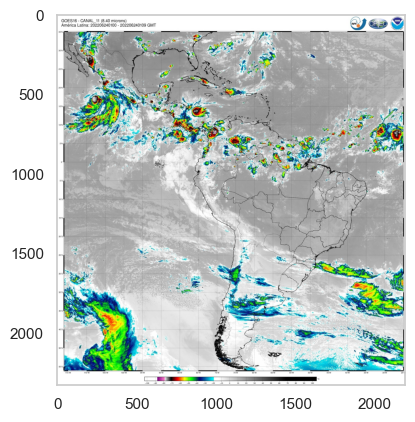

In [319]:
sns.set_style("whitegrid", {'axes.grid' : False})
plt.imshow(img)
plt.show()

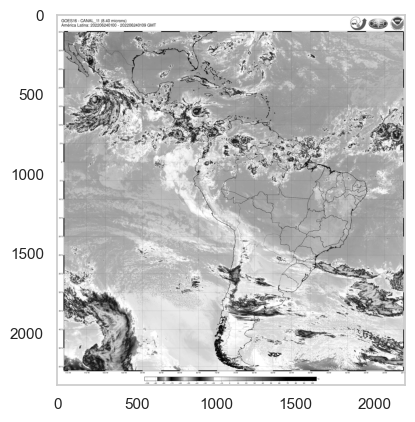

In [320]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap="gray")

In [321]:
m, M = 1004, 2058
m1, M1 = 808, 1744

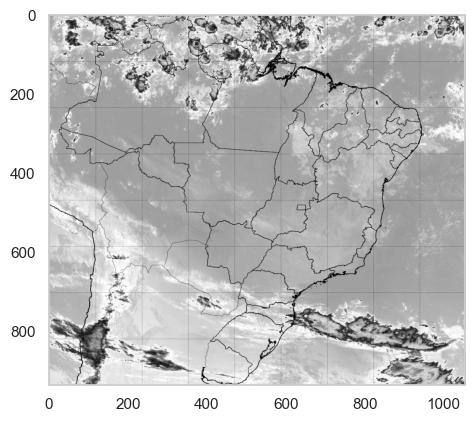

In [322]:
map = gray[m1:M1, m:M]
plt.imshow(map, cmap="gray")

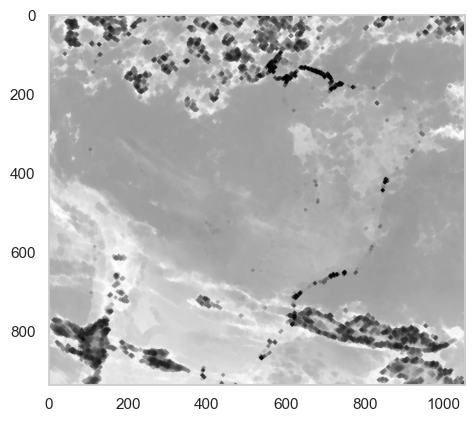

In [323]:
map = cv2.morphologyEx(map, cv2.MORPH_CLOSE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=2)
map = cv2.morphologyEx(map, cv2.MORPH_ERODE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=3)
plt.imshow(map, cmap="gray")

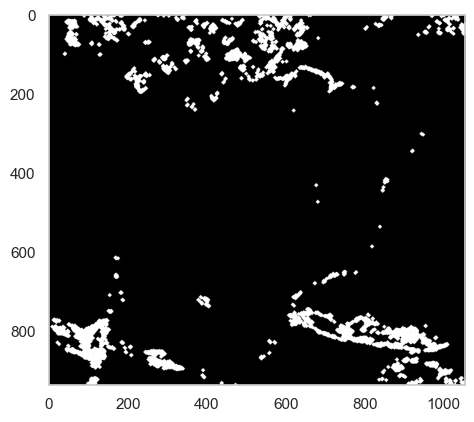

In [324]:
_, map = cv2.threshold(255 - map, 130, 255, cv2.THRESH_BINARY)
plt.imshow(map, cmap="gray")

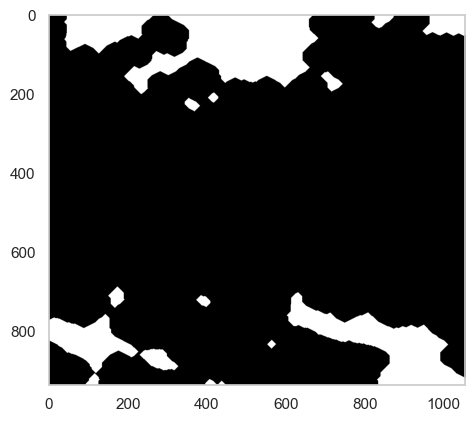

In [325]:
map = cv2.morphologyEx(map, cv2.MORPH_CLOSE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=10)
map = cv2.morphologyEx(map, cv2.MORPH_OPEN, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=10)

plt.imshow(map, cmap="gray")

In [326]:
masked_img = img.copy()
masked_img[m1:M1, m:M] = np.uint8(cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel=np.ones((3, 3)), iterations=3)[m1:M1, m:M])
masked_img[m1:M1, m:M] = masked_img[m1:M1, m:M] * (map / map.max())[..., np.newaxis]

In [327]:
def to_image_coords(lat, lon):
    m, M = 1004, 2058
    m1, M1 = 808, 1744
    x0, x1 = -30, -75
    y0, y1 = 5, -35
    px = int(np.floor(((lon - x0) / (x1 - x0)) * (m - M) + M))
    py = int(np.floor(((lat - y0) / (y1 - y0)) * (M1 - m1) + m1))
    return px, py

In [328]:
ori_lat, ori_lon = -27.67070, -48.54697
dst_lat, dst_lon = -19.63571, -43.96693

In [329]:
ori = to_image_coords(ori_lat, ori_lon)
dst = to_image_coords(dst_lat, dst_lon)

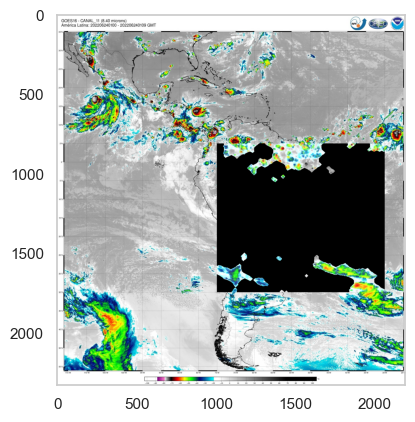

In [330]:
#cv2.circle(image, ori, 5, (255, 0, 255), -1)
#cv2.circle(image, dst, 5, (255, 0, 255), -1)
plt.imshow(masked_img)

In [331]:
if ori[1] < dst[1]:
    angle = np.rad2deg(np.arctan2(-(dst[1] - ori[1]), -(dst[0] - ori[0])))
else:
    angle = np.rad2deg(np.arctan2((dst[1] - ori[1]), (dst[0] - ori[0])))

In [332]:
image_center = tuple(np.array(masked_img.shape[:2][::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
result = cv2.warpAffine(masked_img, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

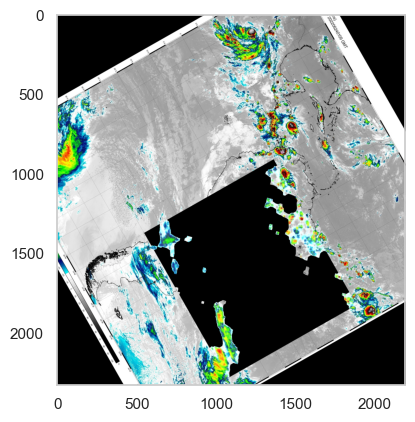

In [333]:
plt.imshow(result)

In [306]:
ct = np.cos(np.deg2rad(angle))
st = np.sin(np.deg2rad(angle))

In [307]:
ax = ori[0] * ct + ori[1] * st + (1 - ct) * image_center[0] - st * image_center[1] 
ay = -ori[0] * st + ori[1] * ct + st * image_center[0] + (1 - ct) * image_center[1] 
nori = int(ax), int(ay)
nori

(1218, 1823)

In [308]:
ax = dst[0] * ct + dst[1] * st + (1 - ct) * image_center[0] - st * image_center[1] 
ay = -dst[0] * st + dst[1] * ct + st * image_center[0] + (1 - ct) * image_center[1] 
ndst = int(ax), int(ay)
ndst

(1002, 1823)

In [309]:
half_b = 35
if ndst[0] < nori[0]:
    d = nori[0] - ndst[0]
    box = [ndst[0] - half_b, ndst[1] - half_b, d + 2 * half_b, 2 * half_b]
else:
    d = ndst[0] - nori[0]
    box = [nori[0] - half_b, nori[1] - half_b, d + 2 * half_b, 2 * half_b ]
print(box)

[967, 1788, 286, 70]


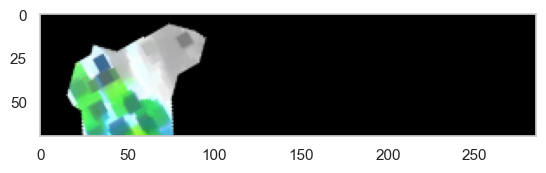

In [310]:
roi = result[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]
plt.imshow(roi)

In [18]:
def get_masked_roi(image, ori, dst):
    def to_image_coords(lat, lon):
        m, M = 1004, 2058
        m1, M1 = 808, 1744
        x0, x1 = -30, -75
        y0, y1 = 5, -35
        px = int(np.floor(((lon - x0) / (x1 - x0)) * (m - M) + M))
        py = int(np.floor(((lat - y0) / (y1 - y0)) * (M1 - m1) + m1))
        return px, py
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    m, M = 1004, 2058
    m1, M1 = 808, 1744
    map = gray[m1:M1, m:M]
    map = cv2.morphologyEx(map, cv2.MORPH_CLOSE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=2)
    map = cv2.morphologyEx(map, cv2.MORPH_ERODE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=3)
    _, map = cv2.threshold(255 - map, 130, 255, cv2.THRESH_BINARY)
    map = cv2.morphologyEx(map, cv2.MORPH_CLOSE, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=10)
    map = cv2.morphologyEx(map, cv2.MORPH_OPEN, kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)), iterations=10)
    masked_img = img.copy()
    masked_img[m1:M1, m:M] = np.uint8(cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel=np.ones((3, 3)), iterations=3)[m1:M1, m:M])
    masked_img[m1:M1, m:M] = masked_img[m1:M1, m:M] * (map / map.max())[..., np.newaxis]

    ori = to_image_coords(*ori)
    dst = to_image_coords(*dst)
    if ori[1] < dst[1]:
        angle = np.rad2deg(np.arctan2(-(dst[1] - ori[1]), -(dst[0] - ori[0])))
    else:
        angle = np.rad2deg(np.arctan2((dst[1] - ori[1]), (dst[0] - ori[0])))
    image_center = tuple(np.array(masked_img.shape[:2][::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rotated = cv2.warpAffine(masked_img, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    ct = np.cos(np.deg2rad(angle))
    st = np.sin(np.deg2rad(angle))
    ax = ori[0] * ct + ori[1] * st + (1 - ct) * image_center[0] - st * image_center[1] 
    ay = -ori[0] * st + ori[1] * ct + st * image_center[0] + (1 - ct) * image_center[1] 
    nori = int(ax), int(ay)
    ax = dst[0] * ct + dst[1] * st + (1 - ct) * image_center[0] - st * image_center[1] 
    ay = -dst[0] * st + dst[1] * ct + st * image_center[0] + (1 - ct) * image_center[1] 
    ndst = int(ax), int(ay)

    half_b = 35
    if ndst[0] < nori[0]:
        d = nori[0] - ndst[0]
        box = [ndst[0] - half_b, ndst[1] - half_b, d + 2 * half_b, 2 * half_b]
    else:
        d = ndst[0] - nori[0]
        box = [nori[0] - half_b, nori[1] - half_b, d + 2 * half_b, 2 * half_b]
    return rotated[box[1]:box[1]+box[3], box[0]:box[0]+box[2]]

In [ ]:
plt.imshow(get_masked_roi(image, [ori_lat, ori_lon], [dst_lat, dst_lon]))

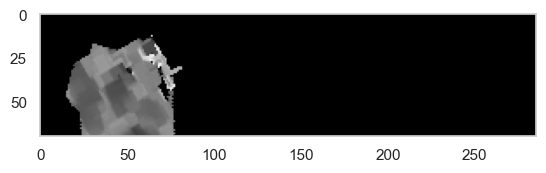

In [312]:
h, s, v = cv2.split(cv2.cvtColor(roi, cv2.COLOR_RGB2HSV))
plt.imshow(h, cmap="gray")

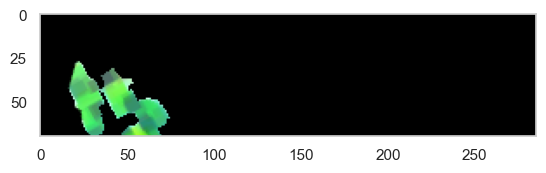

In [313]:
yellow_green = (h > 35) * (h < 85) * (s > 50)
plt.imshow(roi * yellow_green[..., np.newaxis], cmap="gray")

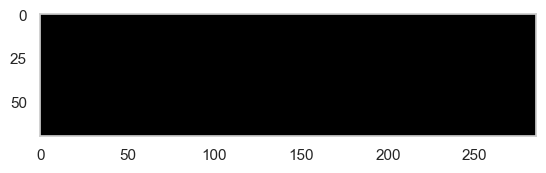

In [314]:
purple_red = ((h < 34) + (h > 130)) * (s > 50)
plt.imshow(roi * purple_red[..., np.newaxis], cmap="gray")

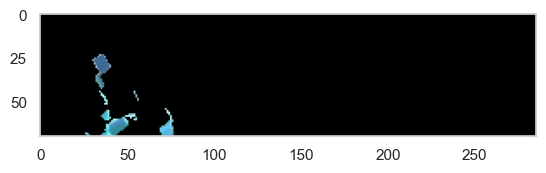

In [315]:
blue = (h > 90) * (h < 130) * (s > 50)
plt.imshow(roi * blue[..., np.newaxis], cmap="gray")

In [20]:
def color_proportions(roi):
    h, s, v = cv2.split(cv2.cvtColor(roi, cv2.COLOR_RGB2HSV))
    yellow_green = (h > 35) * (h < 85) * (s > 50)
    purple_red = ((h < 34) + (h > 130)) * (s > 50)
    blue = (h > 90) * (h < 130) * (s > 50)
    return list(color_mask.sum() / color_mask.size for color_mask in [yellow_green, purple_red, blue])

In [339]:
color_proportions(roi)

[0.06373626373626373, 0.0, 0.016483516483516484]

In [21]:
airport_data = pl.read_csv(data_dir / "airports.csv")
airport_data

ICAO,lat,lon,n_pistas,desig_pista1,desig_pista2
str,f64,f64,i64,str,str
"""SBCF""",-19.63571,-43.96693,1,"""16/34""","""NA"""
"""SBSP""",-23.62695,-46.65503,2,"""17R/35L""","""17L/35R"""
"""SBGR""",-23.43227,-46.46948,2,"""10L/28R""","""10R/28L"""
"""SBKP""",-23.0074,-47.1345,1,"""15/33""","""NA"""
"""SBRF""",-8.12598,-34.92332,1,"""18/36""","""NA"""
…,…,…,…,…,…
"""SBBR""",-15.8712,-47.91933,2,"""11R/29L""","""11L/29R"""
"""SBCT""",-25.52882,-49.17316,2,"""15/33""","""11/29"""
"""SBSV""",-12.91095,-38.33108,2,"""10/28""","""17/35"""


In [45]:
image_dir = data_dir / "images"
imgs = list(sorted(glob(str(image_dir / "*"))))
columns = [
    "sat_yellow_green", "sat_purple_red", "sat_blue"
]

yellow_green, purple_red, blue = [], [], []
d = dict()
for i in tqdm(range(main_ds.shape[0])):
    try:
        url = main_ds["url_img_satelite"][i]
        origem = main_ds["origem"][i]
        origem = airport_data.filter(pl.col("ICAO") == origem)[["lat", "lon"]].to_numpy()[0].tolist()
        destino = main_ds["destino"][i]
        destino = airport_data.filter(pl.col("ICAO") == destino)[["lat", "lon"]].to_numpy()[0].tolist()
        filename = url.split("/")[-1]
        path = image_dir / filename
        img = mpimg.imread(path)
        roi = get_masked_roi(img, origem, destino)
        yg, pr, bb = color_proportions(roi)
        yellow_green.append(yg)
        purple_red.append(pr)
        blue.append(bb)
    except:
        yellow_green.append(None)
        purple_red.append(None)
        blue.append(None)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 211679/211679 [6:13:29<00:00,  9.45it/s]


In [46]:
image_color_data = pl.DataFrame([yellow_green, purple_red, blue], schema=columns)
image_color_data

sat_yellow_green,sat_purple_red,sat_blue
f64,f64,f64
0.24016,0.031169,0.063786
0.000376,0.0,0.0
0.272527,0.084537,0.091209
0.437748,0.112204,0.067739
0.126246,0.04079,0.042082
…,…,…
0.0,0.0,0.029754
0.000055,0.0,0.027563
0.0,0.0,0.027829


In [48]:
image_color_data.write_csv("image_color_data.csv", null_value="NA")

In [49]:
metar_data.write_csv("metar_data.csv", null_value="NA")